In [1]:
# importing all necessary libraries
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import secrets
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [14]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
# creating directories for training and testing images 
TEST_DIR = os.path.join(os.getcwd(),"imgs","test")
TRAIN_DIR = os.path.join(os.getcwd(),"imgs","train")
MODEL_PATH = os.path.join(os.getcwd(),"model","self_trained")
PICKLE_DIR = os.path.join(os.getcwd(),"pickle_files")
CSV_DIR = os.path.join(os.getcwd(),"csv_files")

In [3]:
if not os.path.exists(TEST_DIR):
    print("Testing data does not exists")
if not os.path.exists(TRAIN_DIR):
    print("Training data does not exists")
if not os.path.exists(MODEL_PATH):
    print("Model path does not exists")
    os.makedirs(MODEL_PATH)
    print("Model path created")
if not os.path.exists(PICKLE_DIR):
    os.makedirs(PICKLE_DIR)
if not os.path.exists(CSV_DIR):
    os.makedirs(CSV_DIR)

In [4]:
# defining parameters for image data generator
gen_per_image = 1
gen_per_class = 200
rotation_range = 5
width_shift_range = 0.02
height_shift_range = 0.02
shear_range = 0.01
zoom_range = 0.05
horizontal_flip = False
fill_mode = "nearest"

In [5]:
# defining 3 functions on basis of which we will generate different images over the existing training images using the imagedatagenerator
def increase_brightness(img,value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
def change_contrast(img,level):
    img=Image.fromarray(img.astype('uint8'))
    factor=(259*(level+255))/(255*(259-level))
    def contrast(c):
        return 128+factor*(c-128)
    return np.array(img.point(contrast))
def pad_img(img):
    h, w = img.shape[:2]
    new_h = int((5 + secrets.randbelow(16)) * h / 100) + h
    new_w = int((5 + secrets.randbelow(16)) * w / 100) + w
    full_sheet = np.ones((new_h, new_w, 3)) * 255
    
    p_X = secrets.randbelow(new_h - img.shape[0])
    p_Y = secrets.randbelow(new_w - img.shape[1])
    
    full_sheet[p_X : p_X + img.shape[0], p_Y : p_Y + img.shape[1]] = img
    full_sheet = cv2.resize(full_sheet, (w, h), interpolation = cv2.INTER_AREA)
    return full_sheet.astype(np.uint8)
def preprocess_img(img):
    img = np.array(img)

    x = secrets.randbelow(2)

    if x == 0:
        # img = pad_img(img)
        img = increase_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
    else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = increase_brightness(img, secrets.randbelow(26))

    return img

In [6]:
# initialising batch size,image size and number of epochs
BATCH_SIZE = 128
IMAGE_SIZE = 224
NUM_EPOCH = 25

In [9]:
datagen = ImageDataGenerator(
        rotation_range = rotation_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range,
        shear_range = shear_range,
        zoom_range = zoom_range,
        horizontal_flip = horizontal_flip,
        fill_mode = fill_mode,
        validation_split = 0.5,
        preprocessing_function = preprocess_img)


train_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='training',shuffle=False)

valid_data = datagen.flow_from_directory(TRAIN_DIR,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=BATCH_SIZE,
                                        subset='validation',shuffle=False)

Found 11215 images belonging to 10 classes.
Found 11209 images belonging to 10 classes.


In [10]:
# Defining the Model 
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 128)     32896     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 28, 28, 256)      

In [11]:
# compiling the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
filepath = os.path.join(MODEL_PATH,"distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [13]:
# fitting our model
model_history = model.fit(train_data,validation_data = valid_data,epochs=NUM_EPOCH,shuffle=True,callbacks=callbacks_list)

Epoch 1/25


88/88 [==============================] - ETA: 0s - loss: 226.1600 - accuracy: 0.0701
Epoch 1: val_accuracy improved from -inf to 0.15175, saving model to C:\Users\manis\Desktop\Untitled Folder\model\self_trained\distracted-01-0.15.hdf5


C:\Users\manis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 782s 9s/step - loss: 226.1600 - accuracy: 0.0701 - val_loss: 2.2928 - val_accuracy: 0.1518
Epoch 2/25
88/88 [==============================] - ETA: 0s - loss: 3.5580 - accuracy: 0.0818
Epoch 2: val_accuracy did not improve from 0.15175
88/88 [==============================] - 784s 9s/step - loss: 3.5580 - accuracy: 0.0818 - val_loss: 2.2855 - val_accuracy: 0.1139
Epoch 3/25
88/88 [==============================] - ETA: 0s - loss: 2.7478 - accuracy: 0.0809
Epoch 3: val_accuracy did not improve from 0.15175
88/88 [==============================] - 757s 9s/step - loss: 2.7478 - accuracy: 0.0809 - val_loss: 2.2890 - val_accuracy: 0.1237
Epoch 4/25
88/88 [==============================] - ETA: 0s - loss: 2.4274 - accuracy: 0.1255
Epoch 4: val_accuracy improved from 0.15175 to 0.20350, saving model to C:\Users\manis\Desktop\Untitled Folder\model\self_trained\distracted-04-0.20.hdf5
88/88 [==============================] - 765s 9s/step - loss: 2.4274 -

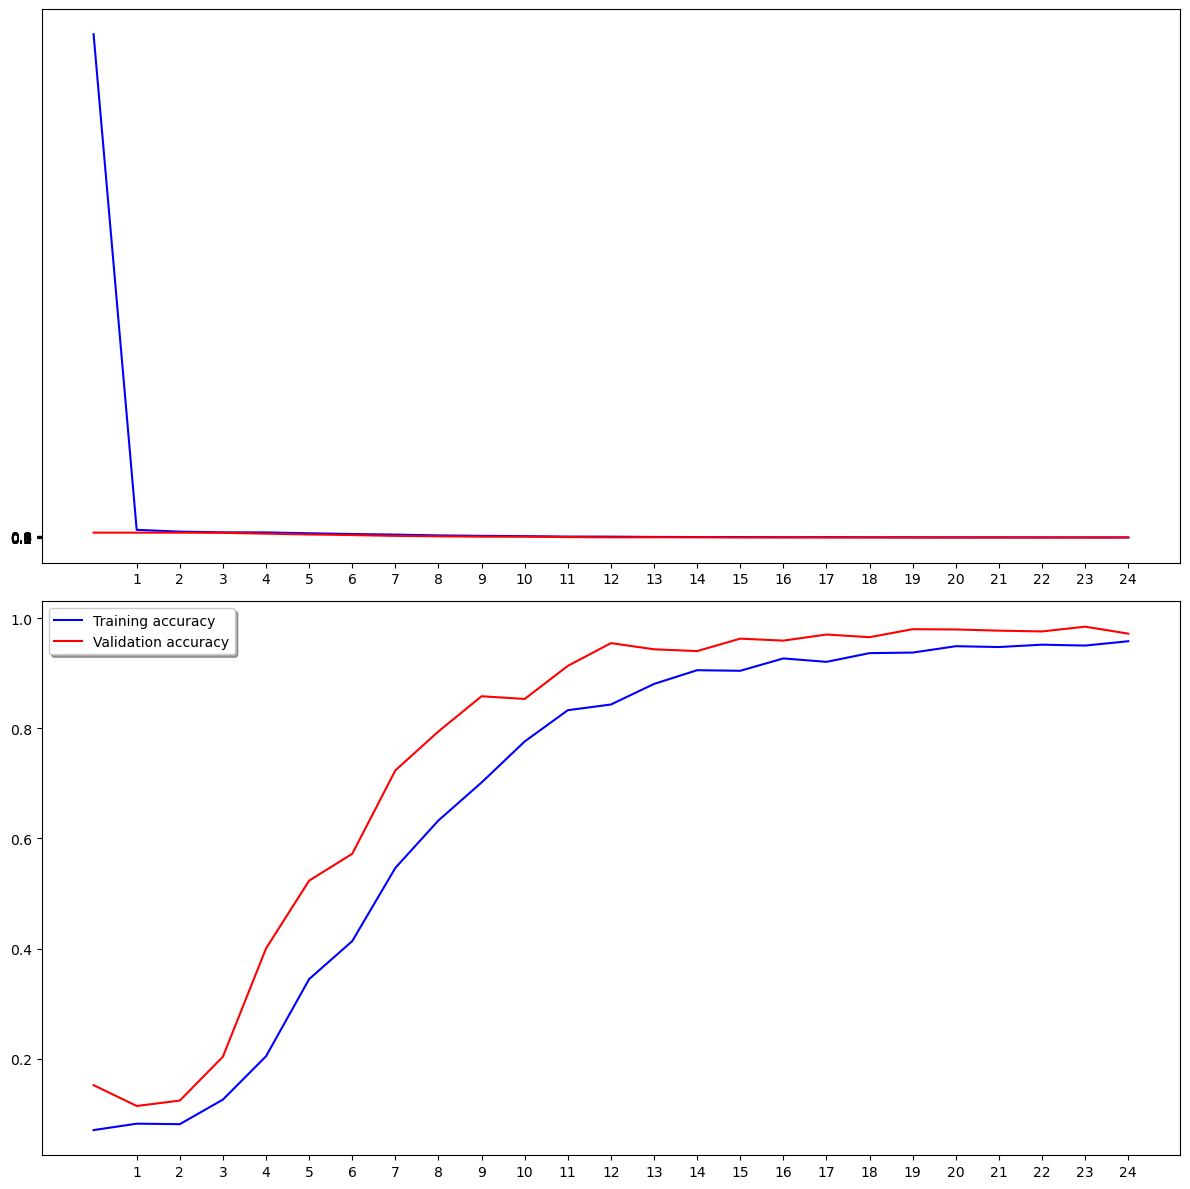

In [14]:
# plotting training and validation accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(model_history.history['loss'], color='b', label="Training loss")
ax1.plot(model_history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 25, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(model_history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(model_history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 25, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [15]:
# defining function to print the confusion matrix
def getConfusionMatrix(confusion_matrix,class_names,figsize=(10,7),fontsize=15):
    df_cm=pd.DataFrame(confusion_matrix,index=class_names,columns=class_names)
    fig=plt.figure(figsize=figsize)
    try:
        heatmap=sns.heatmap(df_cm,annot=True,fmt="d")
    except ValueError:
        raise ValueError("Matix values are not integer")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(os.path.join(MODEL_PATH,"confusion_matrix.png"))
    return fig

In [16]:
def printHeatMap(n_labels,n_predictions,class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix=confusion_matrix(labels,predictions.argmax(axis=1))
    row_sum=np.sum(matrix,axis=1)
    w,h=matrix.shape
    c_m=np.zeros((w,h))
    
    for i in range(h):
        c_m[i]=matrix[i]*100/row_sum[i]
    c=c_m.astype(dtype=np.uint8)
    heatmap=getConfusionMatrix(c,class_names,figsize=(18,10),fontsize=20)
    

In [17]:
ypred=model.predict(valid_data)
valid_list=valid_data.classes.tolist()
y_pred_class=np.argmax(ypred,axis=1)
ytest=valid_list

88/88 [==============================] - 210s 2s/step


In [18]:
class_names=list()
for name,idx in valid_data.class_indices.items():
    class_names.append(name)
print(class_names)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


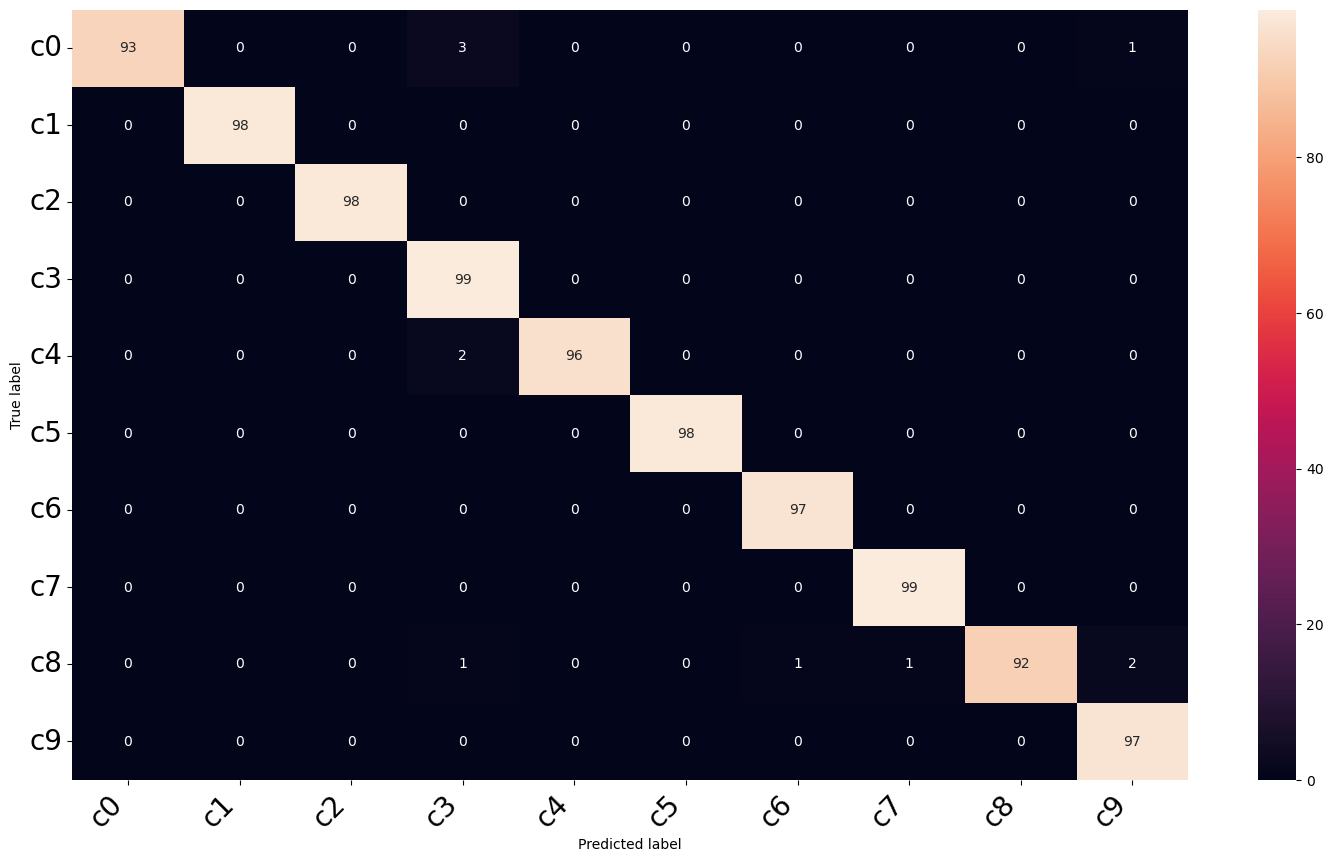

In [19]:
printHeatMap(ytest,ypred,class_names)

In [20]:
# printing accuracy precision recall and F1 Score to analyse our model
accuracy=accuracy_score(ytest,y_pred_class)
precision = precision_score(ytest, y_pred_class,average='weighted')
recall=recall_score(ytest,y_pred_class,average='weighted')
f1=f1_score(ytest,y_pred_class,average='weighted')
print("Accuracy %f" %accuracy)
print("Precision %f" %precision)
print("Recall %f" %recall)
print("F1 Score %f" %f1)

Accuracy 0.973236
Precision 0.974164
Recall 0.973236
F1 Score 0.973228


In [21]:
model.evaluate(valid_data)

88/88 [==============================] - 202s 2s/step - loss: 0.1031 - accuracy: 0.9716


[0.10310771316289902, 0.9716299176216125]

In [96]:
from keras.models import load_model
model = load_model("model\self_trained\distracted-24-0.98.hdf5")

In [97]:
# just to map o/p values
op = dict(zip( train_data.class_indices.values(), train_data.class_indices.keys()))

TypeError: 'dict' object is not callable

In [98]:
from keras.preprocessing.image import img_to_array, load_img

In [99]:
dict={
    'c0':'safe driving',
    'c1':'texting - right',
    'c2': 'talking on the phone - right',
    'c3': "texting - left",
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'
}


1/1 [==============================] - 0s 100ms/step
 the image is of talking on the phone - left


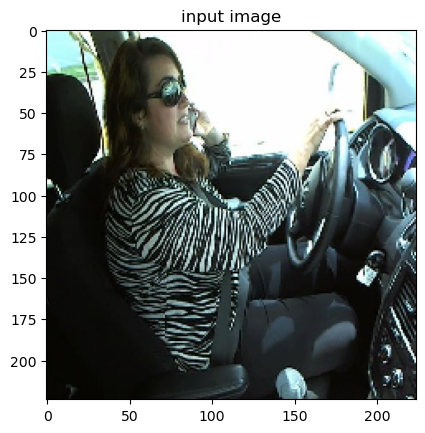

In [101]:
path = "imgs/test/img_15.jpg"
img = load_img(path, target_size=(224,224) )
i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))
value=dict[op[pred]]
print(f" the image is of {value}")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()